In [1]:
import pickle
import numpy as np
import scvelo as scv
import torch
import scanpy as sc
from scipy.sparse import csr_matrix
from veloproj import *
import pandas as pd

scv.settings.verbosity = 1
device = torch.device("cpu")

ModuleNotFoundError: No module named 'numpy'

In [3]:
setalpha = 0.7
alphaidx = 3
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'dentategyrus_model.cpt',
                               '--exp-name', 'CohAE_dentategyrus',
                               '--device', 'cuda:2',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "X",
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'seurat_clusters',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:2', exp_name='CohAE_dentategyrus', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, is_half=False, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-05, lr_decay=0.9, mask_cluster_list=None, model_name='dentategyrus_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='X', output='./', pos_thred=0.01, pos_weight=0.0, refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='seurat_clusters', weight_decay=0.0, z_dim=100)

In [4]:
sample = 'day7'
input_file = '/home/linxy29/holab/iPSC/veloAE/' + sample + '_seurate.h5ad'

In [5]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [6]:
cluster_edges = [("OPC", "OL")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [7]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    #tensor_x = torch.FloatTensor(adata.X).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [8]:
adata = sc.read_h5ad(input_file)
#adata = sc.read_h5ad('/home/linxy29/holab/iPSC/veloAE/' + sample + '_seurate_wTrajectory.h5ad')
adata

AnnData object with n_obs × n_vars = 18708 × 74559
    obs: 'Clusters', '_X', '_Y', 'batch', 'seurat_clusters'
    var: 'Accession-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'Accession-1', 'Chromosome-1', 'End-1', 'Start-1', 'Strand-1'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [9]:
scv.pp.neighbors(adata, n_neighbors=30, n_pcs=15)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=15, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.8 0.2]
AnnData object with n_obs × n_vars = 18708 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'Accession-1', 'Chromosome-1', 'End-1', 'Start-1', 'Strand-1', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


In [10]:
from matplotlib.colors import ListedColormap
color_dict = {
    "Axial progenitors": "#EE9A00",
    "axial progenitors": "#EE9A00",
    "Axial/neuromesodermal progenitors": "#6cb4ef",
    "cardiac": "#CD5C5C",
    "Cardiac mesoderm": "#CD5C5C",
    "endoderm": "#BDB76B",
    "Endoderm": "#BDB76B",
    "Homeostasis/stress": "#ffe5a5",
    "Paraxial mesoderm": "#fa6616",
    "Paraxial mesoderm progenitors": "#FF6347",
    "paraxial mesoderm progenitors": "#FF6347",
    "Lateral/paraxial mesoderm progenitors": "#FF6347",
    "lateral/paraxial mesoderm": "#FF6347",
    "Neuroectoderm": "#104E8B",
    "Neurectoderm": "#104E8B",
    "neuroectoderm": "#104E8B",
    "Neuromesodermal progenitors": "#5CACEE",
    "neuromesodermal progenitors": "#5CACEE",
    "Notochord": "#008B00",
    "notochord": "#008B00",
    "Primitive streak (cluster3)": "#666666",
    "primitive streak": "#666666",
    "Primitive streak (cluster4)": "#8B8B83",
    "Primitive streak-1": "#666666",
    "Primitive streak-2": "#8B8B83",
    "Primitive streak": "#666666",
    "Sclerotome": "#8f0000",
    "Somitic mesoderm": "#556b2f",
    "axial skeleton system": "#f5deb3"
}
print(adata.obs[args.vis_type_col].cat.categories)
## generate color_vect based on the adata.obs[args.vis_type_col].cat.categories
celltypeL = [celltype.replace("_", " ") for celltype in adata.obs[args.vis_type_col].cat.categories]
print(celltypeL)
color_vect = [color_dict[celltype] for celltype in celltypeL]
#color_vect = ["#EE9A00","#CD5C5C","#BDB76B","#FF6347","#104E8B","#5CACEE","#008B00","#666666","#8B8B83"]
print(color_vect)

Index(['axial progenitors', 'cardiac', 'endoderm', 'neuroectoderm',
       'neuromesodermal progenitors', 'notochord',
       'paraxial mesoderm progenitors', 'primitive streak'],
      dtype='object')
['axial progenitors', 'cardiac', 'endoderm', 'neuroectoderm', 'neuromesodermal progenitors', 'notochord', 'paraxial mesoderm progenitors', 'primitive streak']
['#EE9A00', '#CD5C5C', '#BDB76B', '#104E8B', '#5CACEE', '#008B00', '#FF6347', '#666666']


In [11]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')

  0%|          | 0/18708 [00:00<?, ?cells/s]

saving figure to file /home/linxy29/holab/iPSC/veloAE/cfseu_scVelo_definedColor_arrow2.png


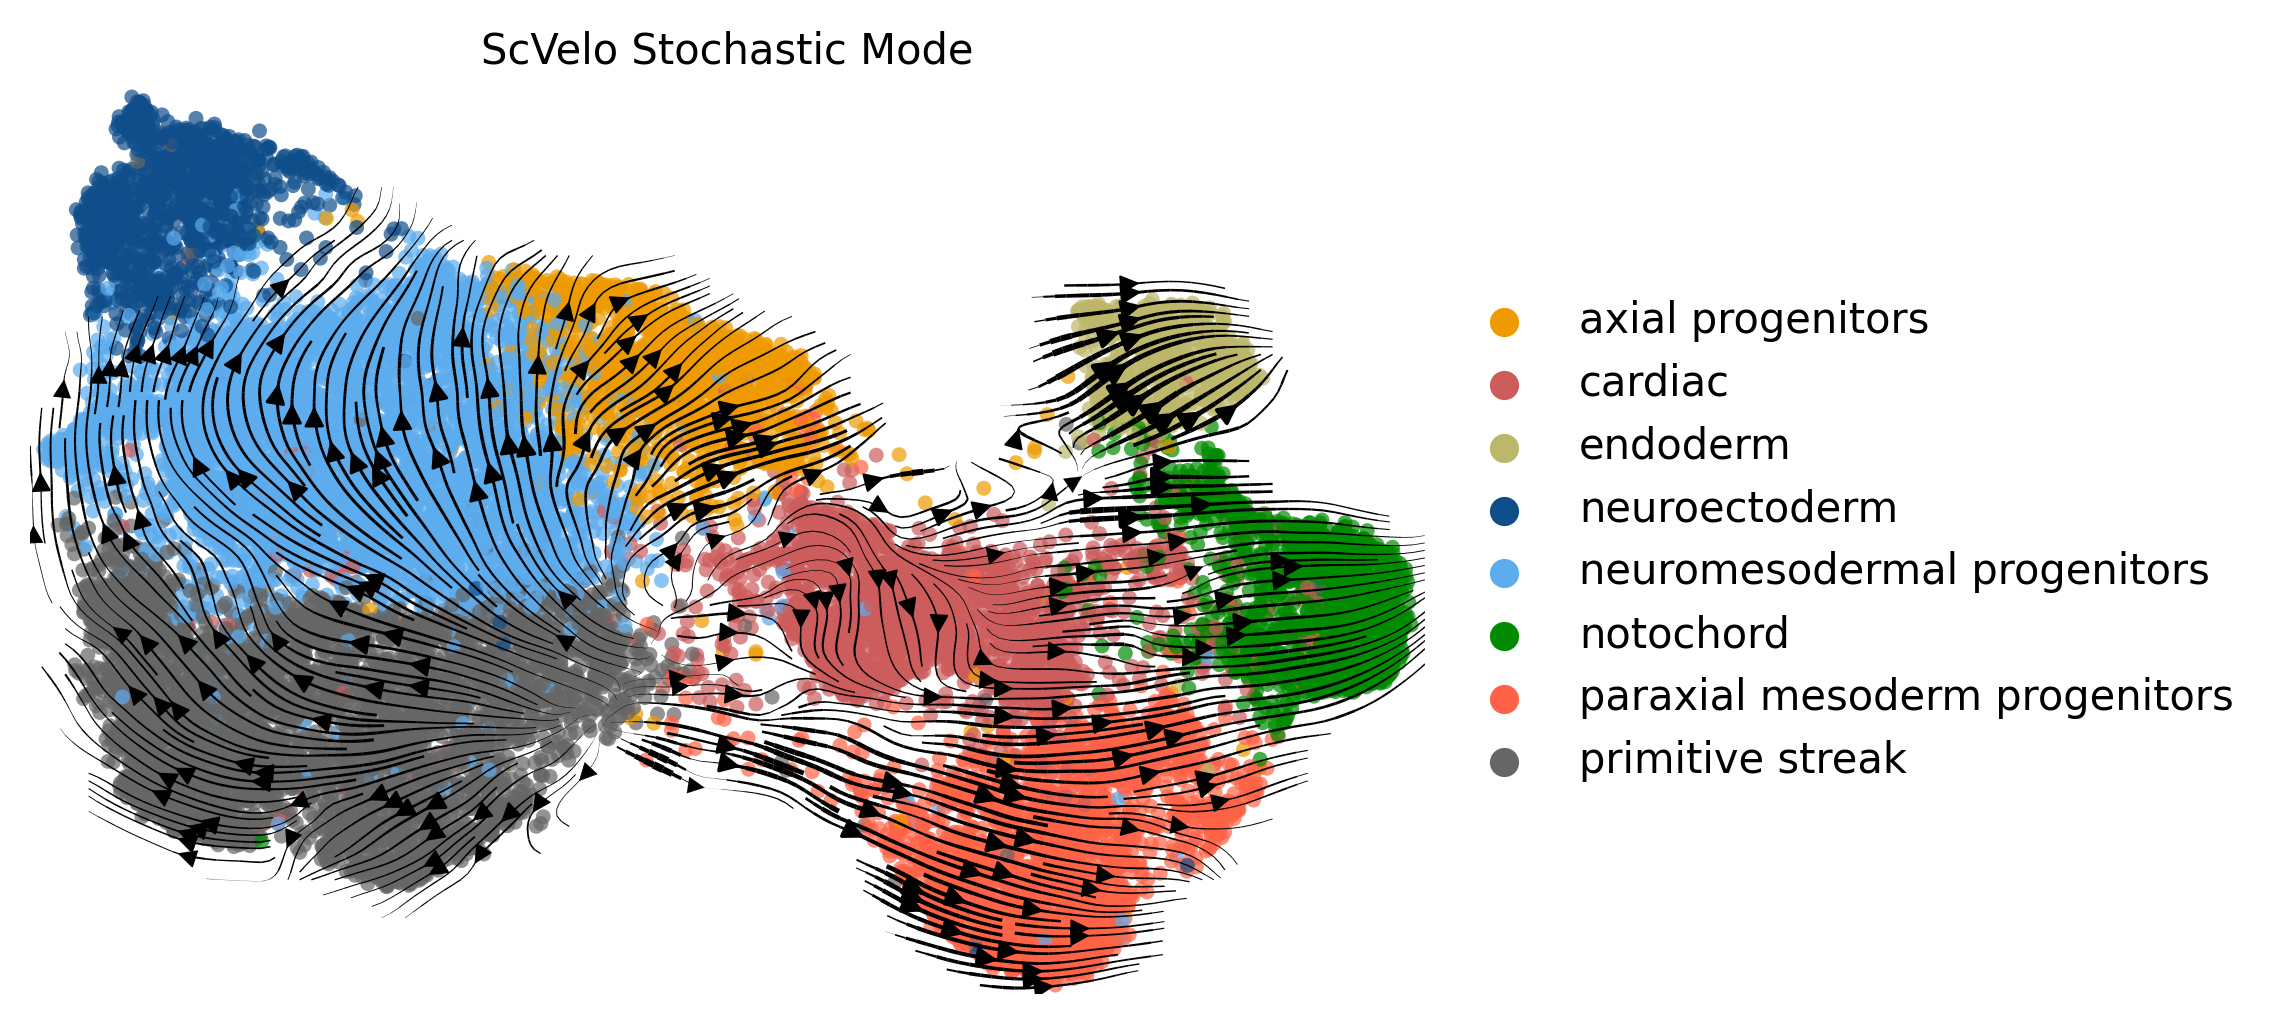

saving figure to file /home/linxy29/holab/iPSC/veloAE/cfseu_scVelo_definedColor_arrow1.png


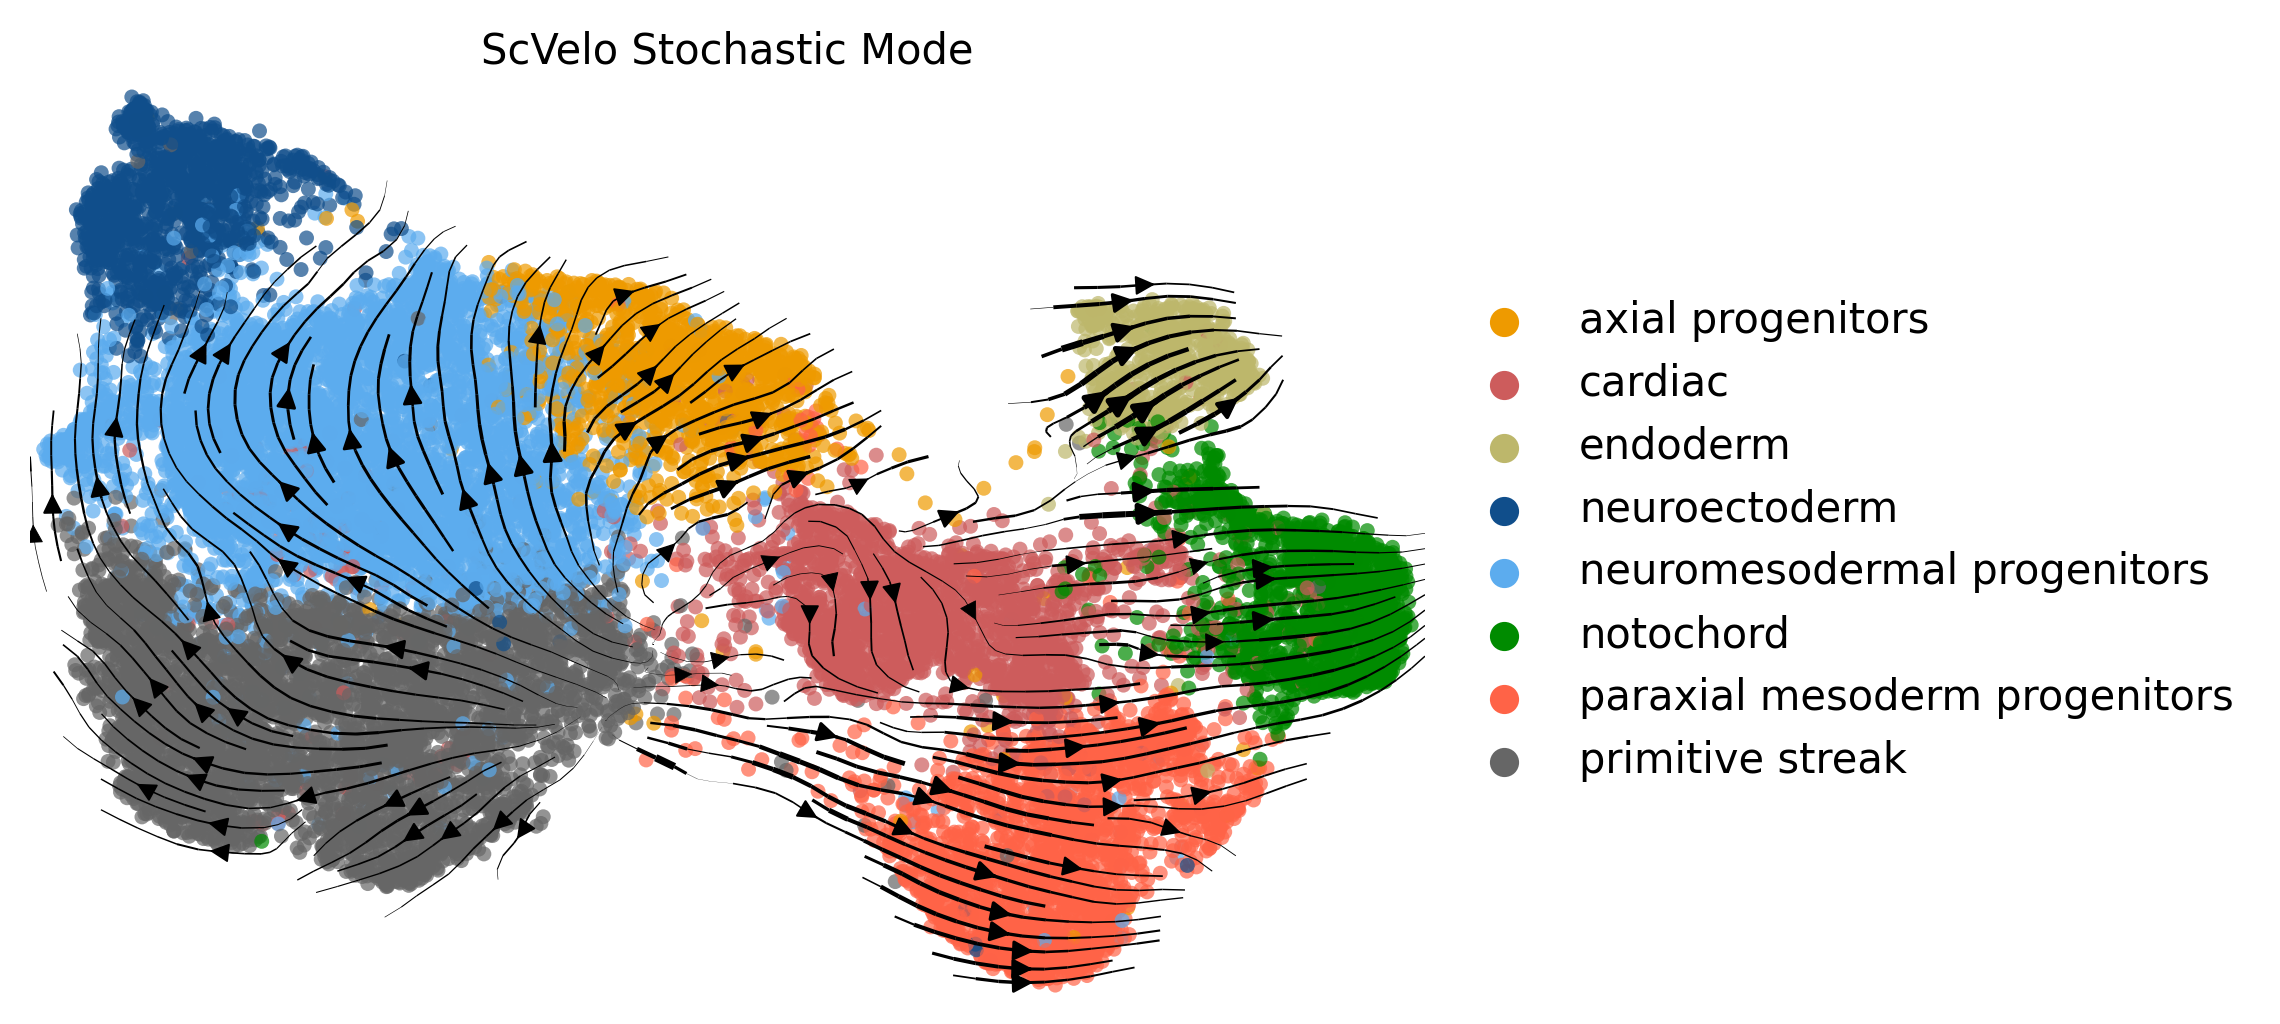

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'axial progenitors': 0.9660188, 'cardiac': 0.94107676, 'endoderm': 0.86489755, 'neuroectoderm': 0.978107, 'neuromesodermal progenitors': 0.9813123, 'notochord': 0.94274974, 'paraxial mesoderm progenitors': 0.944543, 'primitive streak': 0.97969425}
Total Mean: 0.9497998952865601
# In-cluster Confidence
{'axial progenitors': 0.9096873038190176, 'cardiac': 0.8642088220055614, 'endoderm': 0.8876508162861847, 'neuroectoderm': 0.9027104811640627, 'neuromesodermal progenitors': 0.9165791226182007, 'notochord': 0.8754140037947997, 'paraxial mesoderm progenitors': 0.9035349021072002, 'primitive streak': 0.8705383906154986}
Total Mean: 0.8912904803013157


AnnData object with n_obs × n_vars = 18708 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'Accession-1', 'Chromosome-1', 'End-1', 'Start-1', 'Strand-1', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'pca', 'neighbors', 'stc_velocity_params', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'seurat_clusters_colors'
    obsm: 'X_umap', 'X_pca', 'stc_velocity_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'stc_velocity', 'variance_stc_velocity'
    obsp: 'distances', 'connectivities'

In [12]:
scv.pl.velocity_embedding_stream(adata, density = 4,  legend_loc="right margin", vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col, palette=color_vect, alpha = setalpha,
                                 dpi=300, title='ScVelo Stochastic Mode', save = '/home/linxy29/holab/iPSC/veloAE/' + sample + '_scVelo_definedColor_arrow2.png')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col, palette=color_vect, alpha = setalpha,
                                 dpi=300, title='ScVelo Stochastic Mode', save = '/home/linxy29/holab/iPSC/veloAE/' + sample + '_scVelo_definedColor_arrow1.png')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")
adata

## Identify important genes

In [13]:
scv.tl.rank_velocity_genes(adata, groupby=args.vis_type_col, min_corr=.3, vkey='stc_velocity')
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
## save the dataframe
df.to_csv('/home/linxy29/holab/iPSC/veloAE/' + sample + '_rank_velocity_genes.csv')
df.head()

axial progenitors cardiac endoderm neuroectoderm  \
0             MAML3   ALPK2      FRY       ZNF385D   
1             SLIT2    SOX6  CARMIL1         SRRM4   
2             DACH1  SAMD4A     FYB2          DOK5   
3              GPC3   UNC5C    CHST9         NCAM1   
4          PRICKLE1  CLSTN2     RGL3          DLL3   

  neuromesodermal progenitors notochord paraxial mesoderm progenitors  \
0                      PTPRZ1   COL11A1                          FBN2   
1                       SPON1    PPP3CA                         BICC1   
2                       HOXB7     MAML2                         FLRT2   
3                       SRRM4     RBM20                       ADAMTS6   
4                       MLLT3     ITGB8                         LPAR1   

  primitive streak  
0           LRRC4C  
1            SSUH2  
2           PTPRZ1  
3              PTN  
4         MIR205HG

In [14]:
## read rank velocity genes file
df = pd.read_csv('/home/linxy29/holab/iPSC/veloAE/' + sample + '_rank_velocity_genes.csv', index_col=0)
df
## read the list of TF txt file
with open('/home/linxy29/holab/iPSC/veloAE/TF_names_v_3.txt', 'r') as file:
    # Create an empty list to store the vectors
    TF = []
    # Loop through each line in the file
    for line in file:
        # Strip any whitespace characters from the line and append to the list
        TF.append(line.strip())
TF[0:5]

['AC008770.3', 'AC023509.3', 'AC092835.1', 'AC138696.1', 'ADNP']

In [15]:
df_TF_bin = pd.DataFrame(index=range(df.shape[0]))
for celltype in df.columns.tolist():
    df_TF_bin[celltype] = df[celltype].isin(TF)
df_TF_bin

axial progenitors  cardiac  endoderm  neuroectoderm  \
0               False    False     False           True   
1               False     True     False          False   
2                True    False     False          False   
3               False    False     False          False   
4               False    False     False          False   
..                ...      ...       ...            ...   
95              False     True     False          False   
96              False    False     False          False   
97              False     True     False          False   
98              False    False     False          False   
99              False    False     False          False   

    neuromesodermal progenitors  notochord  paraxial mesoderm progenitors  \
0                         False      False                          False   
1                         False      False                          False   
2                          True      False                          False   
3                         False      False                          False   
4                         False      False                          False   
..                          ...        ...                            ...   
95                        False      False                          False   
96                        False      False                          False   
97                        False      False                          False   
98                        False      False                          False   
99                        False      False                          False   

    primitive streak  
0              False  
1              False  
2              False  
3              False  
4              False  
..               ...  
95             False  
96             False  
97             False  
98             False  
99             False  

[100 rows x 8 columns]

In [16]:
df_TF = df[df_TF_bin]
df_TF
# save df_TF
df_TF.to_csv('/home/linxy29/holab/iPSC/veloAE/' + sample + '_rank_velocity_genes_TF.csv')
df_nonTF = df[df_TF_bin == False]
df_nonTF.to_csv('/home/linxy29/holab/iPSC/veloAE/' + sample + '_rank_velocity_genes_nonTF.csv')

In [17]:
## plot the important genes from the dataframe
#for columnName, columnData in df.iteritems():
    #scv.pl.velocity(adata, columnData.values, vkey='stc_velocity', ncols=5, save = '/home/linxy29/holab/iPSC/veloAE/figures/' + sample + '_' + columnName + '.png')

In [18]:
adata.X = csr_matrix(adata.X)
adata

AnnData object with n_obs × n_vars = 18708 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'seurat_clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession-0', 'Chromosome-0', 'End-0', 'Start-0', 'Strand-0', 'Accession-1', 'Chromosome-1', 'End-1', 'Start-1', 'Strand-1', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_qreg_ratio', 'stc_velocity_r2', 'stc_velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'pca', 'neighbors', 'stc_velocity_params', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'seurat_clusters_colors', 'rank_velocity_genes'
    obsm: 'X_umap', 'X_pca', 'stc_velocity_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'stc_velocity', 'variance_stc_velocity'
    obsp: 'distances', 'c

Loss: (Total) 14.662927, (AE) 14.572145, (LR) 1.00 * 0.090782，(POS) 0.00 * 6.896851: 100%|██████████| 20000/20000 [37:26<00:00,  8.90it/s]


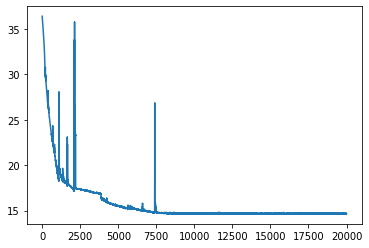

In [19]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

  0%|          | 0/18708 [00:00<?, ?cells/s]

saving figure to file /home/linxy29/holab/iPSC/veloAE/cfseu_veloAE_definedColor_arrow1.png


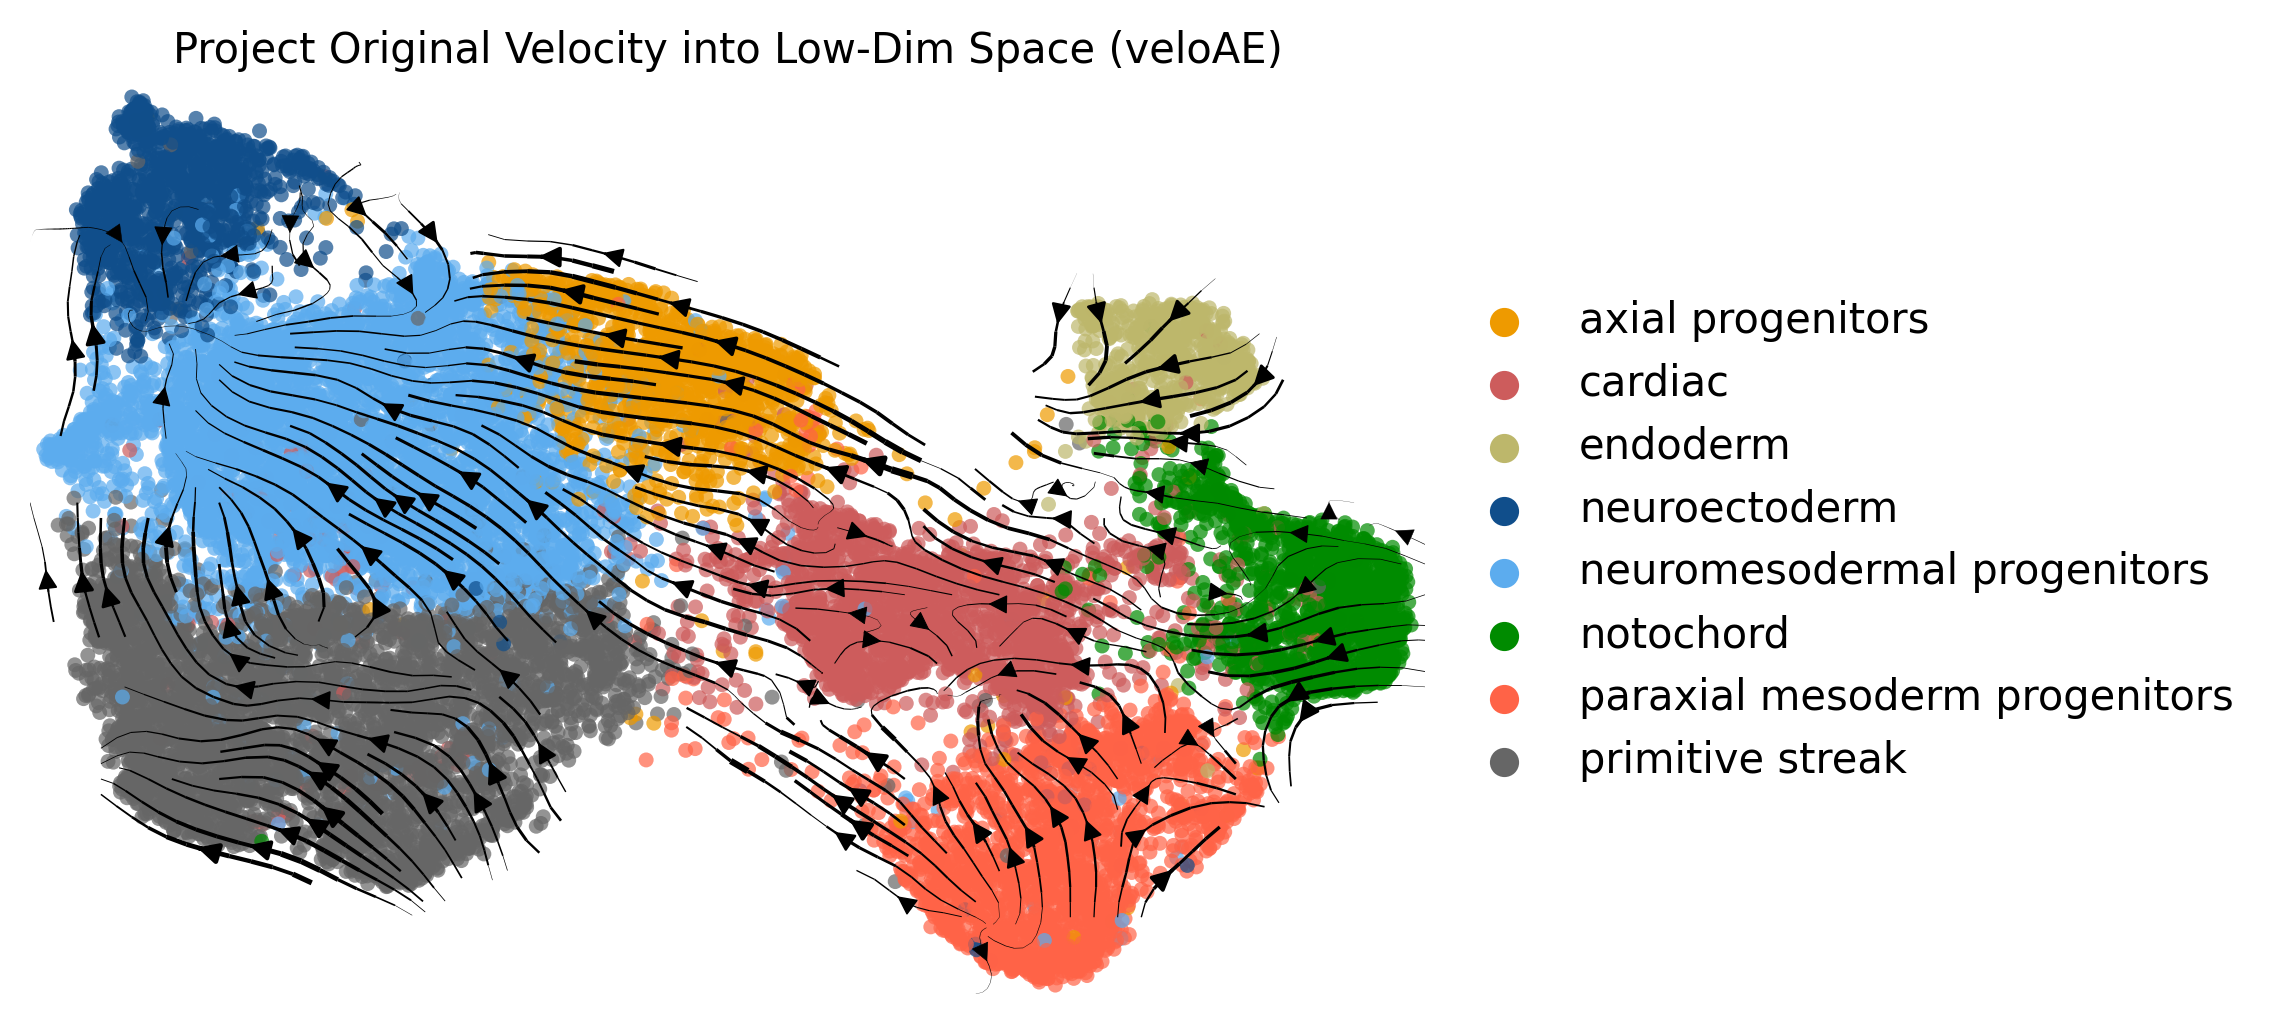

saving figure to file /home/linxy29/holab/iPSC/veloAE/cfseu_veloAE_definedColor_arrow2.png


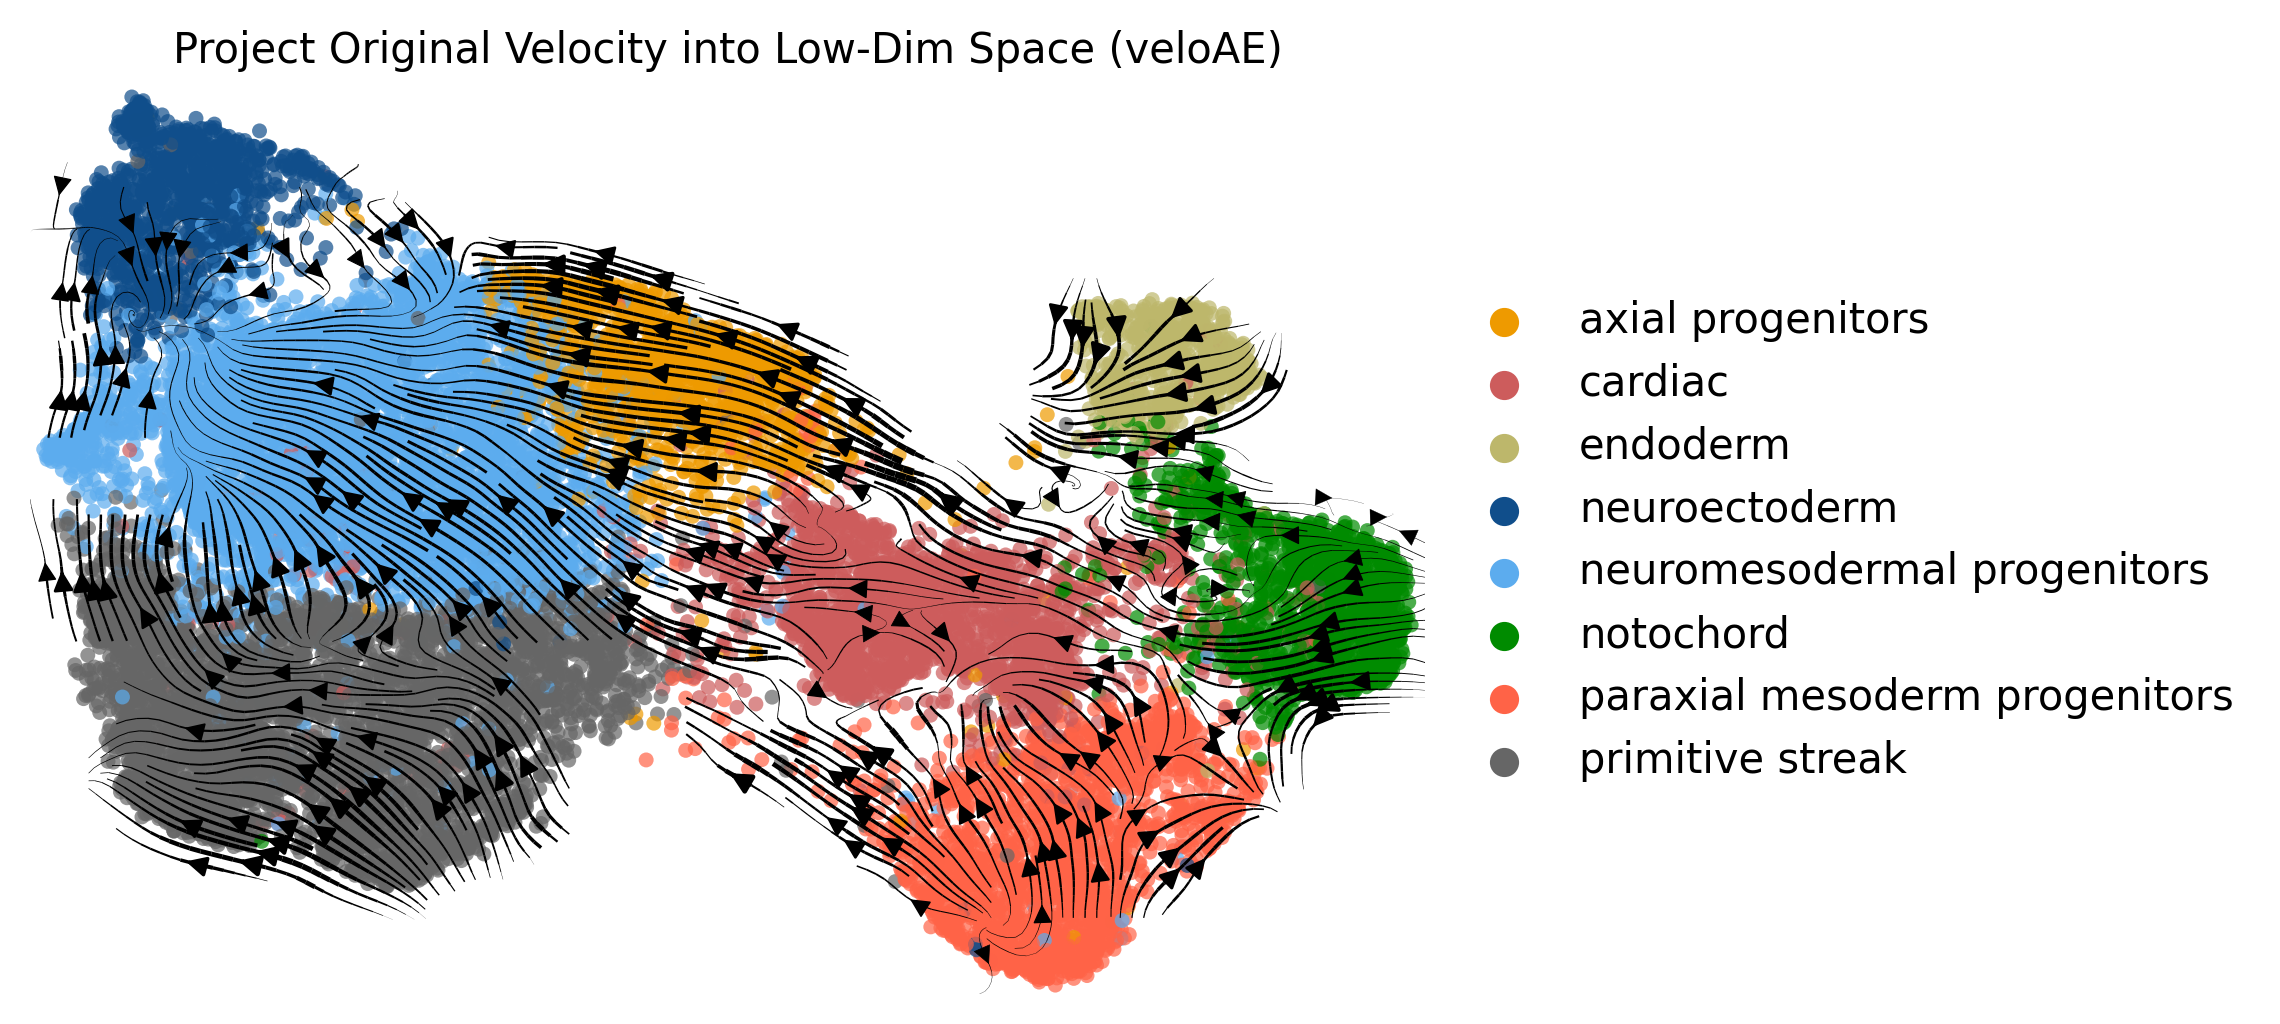

# Cross-Boundary Transition Score (A->B)
{}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{}
Total Mean: nan
# Cross-Boundary Direction Correctness (A->B)
{}
Total Mean: nan
# In-cluster Coherence
{'axial progenitors': 0.99865705, 'cardiac': 0.99790674, 'endoderm': 0.99896955, 'neuroectoderm': 0.9986083, 'neuromesodermal progenitors': 0.99876356, 'notochord': 0.99753445, 'paraxial mesoderm progenitors': 0.9986684, 'primitive streak': 0.998998}
Total Mean: 0.9985132217407227
# In-cluster Confidence
{'axial progenitors': 0.9983186369465891, 'cardiac': 0.9977339231187389, 'endoderm': 0.998734348150621, 'neuroectoderm': 0.998472964158669, 'neuromesodermal progenitors': 0.9986465976203698, 'notochord': 0.9973639613205459, 'paraxial mesoderm progenitors': 0.998525300098321, 'primitive streak': 0.9989333059498113}
Total Mean: 0.9983411296704583


In [20]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        
        spliced = adata.layers['Ms']
        unspliced = adata.layers['Mu']
        tensor_s = torch.FloatTensor(spliced).to(device)
        tensor_u = torch.FloatTensor(unspliced).to(device)
        tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)

        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space (veloAE)", smooth=0.5,
                                    dpi=300, palette=color_vect, alpha = setalpha, 
                                    save='/home/linxy29/holab/iPSC/veloAE/' + sample + '_veloAE_definedColor_arrow1.png')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space (veloAE)", smooth=0.5,
                                    dpi=300, palette=color_vect, density = 4, alpha = setalpha, 
                                    save='/home/linxy29/holab/iPSC/veloAE/' + sample + '_veloAE_definedColor_arrow2.png')
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
exp(adata, exp_metrics)

In [21]:
adata.write('/home/linxy29/holab/iPSC/veloAE/' + sample + '_seurate_wTrajectory.h5ad')

: 